# Read data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from video_processing import read_video_array
from shm_system import SimpleHarmonicSystem

In [2]:
df = pd.read_csv('data/raw/experimental_data.tsv', sep='\t')
df.columns = ['t', 'x', 'y', 'vx', 'vy', 'ax', 'ay', 'unk', 'frame', 'Ek', 'theta']
df = df[['frame','t', 'theta']]

def convert_numeric(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        df[col] = df[col].str.replace(',', '.').astype('float')
    return df

df = convert_numeric(df.astype(str))
df['theta'] = np.deg2rad(df['theta'])
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   frame   129 non-null    float64
 1   t       129 non-null    float64
 2   theta   130 non-null    float64
dtypes: float64(3)
memory usage: 3.2 KB
None


,frame,t,theta
0,140.0,0.000,-0.157080
1,141.0,0.041,-0.162316
2,142.0,0.081,-0.158825
3,143.0,0.123,-0.153589
4,144.0,0.166,-0.144862
...,...,...,...
125,265.0,5.214,0.127409
126,266.0,5.262,0.122173
127,267.0,5.302,0.115192
128,269.0,5.385,0.106465


In [3]:
SYS_CONF = dict(
    theta_0=df['theta'].values[0], # rad
    g=9.77, # m / s**2
    m=5.76, # grams
    L=1, # m
    phi=0 # rad
)

# Periodo

In [21]:
omega = np.sqrt(SYS_CONF['g'] / SYS_CONF['L'])
frecuency = omega / (2 * np.pi)
T = 2 * np.pi / omega

print(f"frecuency: {frecuency} Hz")
print(f"T: {T} s")
print(f"omega: {omega} rad/s")

frecuency: 0.49747059314738395 Hz
T: 2.0101690708454267 s
omega: 3.1256999216175565 rad/s


In [4]:
def delta(y: np.ndarray, x: np.ndarray) -> np.ndarray:
    d = []
    for i in range(len(y)):
        if i > 0 and None in [y[i], y[i-1]]:
            d.append(np.nan)
            continue
        d.append((y[i] - y[i-1])/(x[i] - x[i-1]))
    d = np.array(d)
    return d

df['velocity'] = delta(y=df['theta'].values, x=df['t'].values)
df['acceleration'] = delta(y=df['velocity'].values, x=df['t'].values)
df['kinetic_energy'] = (1/2) * SYS_CONF['m'] * df['velocity']**2
df['potential_energy'] = SYS_CONF['m'] * SYS_CONF['g'] * SYS_CONF['L'] * (1 - np.cos(df['theta']))
df['mechanical_energy'] = df['potential_energy'] + df['kinetic_energy']
df

,frame,t,theta,velocity,acceleration,kinetic_energy,potential_energy,mechanical_energy
0,140.0,0.000,-0.157080,NaN,NaN,NaN,0.692841,NaN
1,141.0,0.041,-0.162316,-0.127707,NaN,0.046970,0.739697,0.786667
2,142.0,0.081,-0.158825,0.087266,5.374337,0.021932,0.708291,0.730223
3,143.0,0.123,-0.153589,0.124666,0.890474,0.044760,0.662450,0.707210
4,144.0,0.166,-0.144862,0.202945,1.820439,0.118618,0.589438,0.708056
...,...,...,...,...,...,...,...,...
125,265.0,5.214,0.127409,-0.035619,0.121153,0.003654,0.456142,0.459796
126,266.0,5.262,0.122173,-0.109083,-1.530502,0.034269,0.419467,0.453736
127,267.0,5.302,0.115192,-0.174533,-1.636246,0.087730,0.372949,0.460679
128,269.0,5.385,0.106465,-0.105140,0.836056,0.031837,0.318633,0.350470


In [5]:
START_FRAME = 142
END_FRAME = 268
df = df[df['frame'].isin(range(START_FRAME, END_FRAME))]
df

,frame,t,theta,velocity,acceleration,kinetic_energy,potential_energy,mechanical_energy
2,142.0,0.081,-0.158825,0.087266,5.374337,0.021932,0.708291,0.730223
3,143.0,0.123,-0.153589,0.124666,0.890474,0.044760,0.662450,0.707210
4,144.0,0.166,-0.144862,0.202945,1.820439,0.118618,0.589438,0.708056
5,145.0,0.208,-0.134390,0.249333,1.104464,0.179040,0.507422,0.686463
6,146.0,0.248,-0.122173,0.305433,1.402497,0.268673,0.419467,0.688139
...,...,...,...,...,...,...,...,...
123,263.0,5.123,0.130900,0.048481,-1.018240,0.006769,0.481442,0.488211
124,264.0,5.165,0.129154,-0.041555,-2.143734,0.004973,0.468707,0.473680
125,265.0,5.214,0.127409,-0.035619,0.121153,0.003654,0.456142,0.459796
126,266.0,5.262,0.122173,-0.109083,-1.530502,0.034269,0.419467,0.453736


In [6]:
df['frame'] = df['frame'].astype('int')
df.set_index('frame', inplace=True)
df

/var/folders/38/7hswkvqn50g49dr_34_92vyw0000gn/T/ipykernel_99641/284222070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['frame'] = df['frame'].astype('int')


,t,theta,velocity,acceleration,kinetic_energy,potential_energy,mechanical_energy
frame,,,,,,,
142,0.081,-0.158825,0.087266,5.374337,0.021932,0.708291,0.730223
143,0.123,-0.153589,0.124666,0.890474,0.044760,0.662450,0.707210
144,0.166,-0.144862,0.202945,1.820439,0.118618,0.589438,0.708056
145,0.208,-0.134390,0.249333,1.104464,0.179040,0.507422,0.686463
146,0.248,-0.122173,0.305433,1.402497,0.268673,0.419467,0.688139
...,...,...,...,...,...,...,...
263,5.123,0.130900,0.048481,-1.018240,0.006769,0.481442,0.488211
264,5.165,0.129154,-0.041555,-2.143734,0.004973,0.468707,0.473680
265,5.214,0.127409,-0.035619,0.121153,0.003654,0.456142,0.459796


# Theoretical vs Experimental systems


In [8]:
ts = SimpleHarmonicSystem(**SYS_CONF)
ts.t = df['t'].values

In [9]:
variables = [
    't', 
    'theta', 
    'velocity', 
    'acceleration', 
    'kinetic_energy', 
    'potential_energy', 
    'mechanical_energy'
]

tdf = pd.DataFrame(index=df.index)

for var in variables:
    attr = getattr(ts, var)
    tdf[var] = attr() if callable(attr) else attr

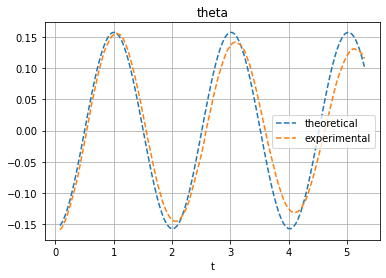

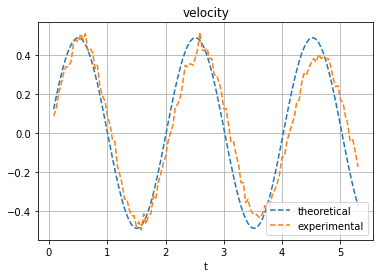

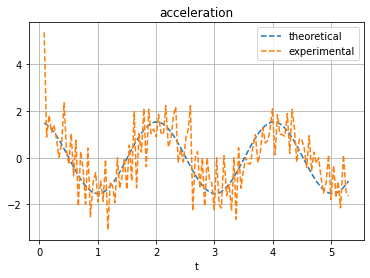

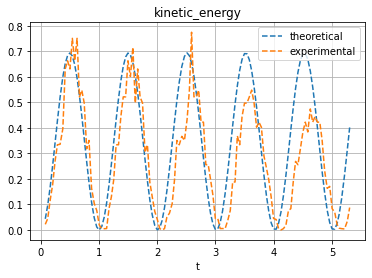

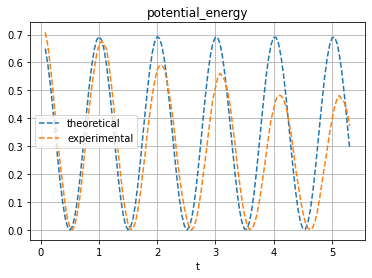

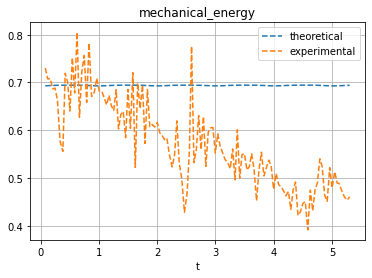

<Figure size 432x288 with 0 Axes>

In [24]:
fig, ax = plt.subplots()
for col in tdf.columns:
    
    if col == 't':
        continue

    tdf.set_index('t')[col].plot(label='theoretical', grid=True, linestyle='--')
    df.set_index('t')[col].plot(label='experimental', grid=True, linestyle='--')
    plt.legend()
    plt.title(col)
    plt.show()
    plt.savefig(f'figures/{col}.png')

In [11]:
tdf

,t,theta,velocity,acceleration,kinetic_energy,potential_energy,mechanical_energy
frame,,,,,,,
142,0.081,-0.152072,0.122984,1.485743,0.043560,0.649454,0.693014
143,0.123,-0.145613,0.184148,1.422638,0.097662,0.595552,0.693214
144,0.166,-0.136405,0.243477,1.332678,0.170729,0.522727,0.693456
145,0.208,-0.125035,0.297194,1.221589,0.254373,0.439321,0.693695
146,0.248,-0.112202,0.343610,1.096213,0.340036,0.353860,0.693896
...,...,...,...,...,...,...,...
263,5.123,0.149830,-0.147438,-1.463840,0.062605,0.630481,0.693087
264,5.165,0.142366,-0.207474,-1.390918,0.123971,0.569334,0.693305
265,5.214,0.130573,-0.272934,-1.275699,0.214540,0.479046,0.693586


In [12]:
df

,t,theta,velocity,acceleration,kinetic_energy,potential_energy,mechanical_energy
frame,,,,,,,
142,0.081,-0.158825,0.087266,5.374337,0.021932,0.708291,0.730223
143,0.123,-0.153589,0.124666,0.890474,0.044760,0.662450,0.707210
144,0.166,-0.144862,0.202945,1.820439,0.118618,0.589438,0.708056
145,0.208,-0.134390,0.249333,1.104464,0.179040,0.507422,0.686463
146,0.248,-0.122173,0.305433,1.402497,0.268673,0.419467,0.688139
...,...,...,...,...,...,...,...
263,5.123,0.130900,0.048481,-1.018240,0.006769,0.481442,0.488211
264,5.165,0.129154,-0.041555,-2.143734,0.004973,0.468707,0.473680
265,5.214,0.127409,-0.035619,0.121153,0.003654,0.456142,0.459796


In [15]:
tdf.to_csv('data/processed/theoretical_system.csv', index=True)
df.to_csv('data/processed/experimental_system.csv', index=True)

# Plots

In [ ]:
end_frame = START_FRAME + 120
video, fps = read_video_array('data/fisica_video.mp4')

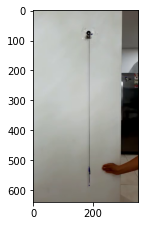

In [ ]:
figsize = tuple(map(lambda x: x / 100, video.shape[1:3]))
plt.figure(figsize=figsize)
plt.imshow(video[0,:,:,:])

# Fuerza

$F = m \text{ } a_T = -m \text{ } g$

$F = m \text{ } a_T = - m \text{ } g \text{ } sin(\theta) $

$ a_T = - \text{ } g \text{ } sin(\theta) $

# Equations

$f(t) = A cos (\omega t + \phi) $

, donde:

$\omega = \sqrt{\frac{g}{L}} $

$ g = 9.77 \frac{m}{s^2} $,

 $L = 1 m$

$A = ?$


para ángulos pequeños $\theta < 20° $, se cumple que $ sin(\theta) \approx \theta $




## Aceleración tangencial


$a_T  = -g \text{ } \theta $

$\frac{d^{2}\theta \text{ } }{dt^{2}} L = a_T$

$\frac{d^{2}\theta }{dt^{2}} = \frac{a_T}{L}$

# Posición

$\theta(t) = \theta_0 \text{ } cos (\omega t + \phi)   $ 

, donde 

$\theta_0 = 8.8 ^{\circ}$


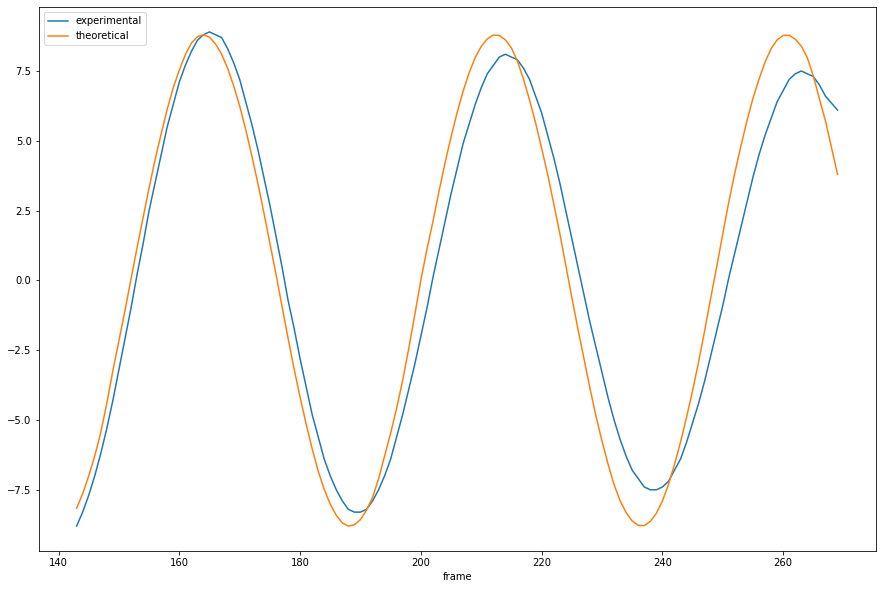

In [ ]:
g = 9.77
L = 1
omega = np.sqrt(g / L)
theta_0 = np.deg2rad(-8.8)
phi = 0
theta = lambda t : theta_0 * np.cos(omega*t + phi)
df['theta_theoretical'] = np.rad2deg(theta(df['t']))

df['angle'].plot(label='experimental', figsize=(15,10))
df['theta_theoretical'].plot(label='theoretical')
plt.legend()
plt.show()

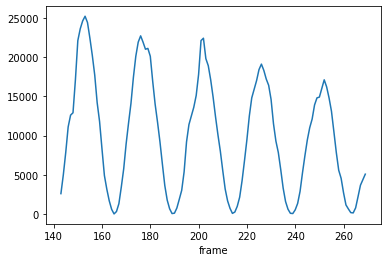

In [ ]:
df['k'].plot()

# Velocidad


$v(t) = -\theta_0 \text{ } \omega \text{ } sin (\omega t + \phi) $


# Aceleración

$a(t) = -\theta_0 \text{ } 𝞈^{2} \text{ } cos (\omega t + \phi) $ 

reorganizando tenemos 

$ a(t) = -\omega^{2} \text{ }  \theta_0 \text{ }  cos (\omega t + \phi) $

que es igual a 

$ a(t) = -\omega^{2} \text{ }  \theta(t) $

# Energías

$E_k = -\frac{1}{2} m (\theta_0 \text{ } \omega \text{ } sin(\omega t + \phi))$

cuando 

$ϴ = 0, E_K$ es máxima


La energía potencial se define como $ E_u = m \text{ } g \text{ } h$, se tiene que

donde $h = L - L cos(\theta)$

$E_u(t) = m \text{ } g \text{ } h =  m \text{ } g \text{ } L \text{ } (1 - cos(\theta(t)))$

cuando $\theta$ = $\theta_0$, $E_u$ es máxima

$E_m = E_u + E_k$


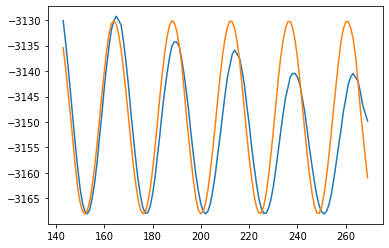

In [ ]:
eu_theoretical = m * g * L * (1 - np.rad2deg(np.cos(np.deg2rad(df['theta_theoretical']))))
plt.plot(eu_exp)
plt.plot(eu_theoretical)